In [1]:
import numpy as np
import pandas as pd
import datetime 
import matplotlib.pyplot as plt 

这份代码是用来回测期权的PCP合成的50ETF期货与中金所股指期货IH对冲套利。
交易分为两个方向
正向（positive）：卖出IH，买入call，卖出put
反向（negative）：买入IH，卖出call，买入put
信号的计算分别是：
pos_signal=((fut_bp1-fut_fee)/50index_preclose)-(call_ap1+K-put_bp1+2*opt_fee)/50etf_pre_nav
neg_signal=((fut_ap1+fut_fee)/50index_preclose)-(call_bp1+K-put_ap1-2*opt_fee)/50etf_pre_nav
以上信号公式中的手续费和价格都需要根据合约乘数进行调整，信号用的是对手价是因为交易时候需要的是即时成交，用对手价的好处就是体现市场实时提供给我们的可得的价格。信号中用到前一交易日的50指数前收盘价和50etf的前净值，因为我们认为etf和指数跟踪误差非常小，长期看来几乎是0.
还有分红，指数是会分红的，而etf期权是红利保护的，所以需要预估红利，这个我已经在数据里面提前处理好了。这个挺复杂，而且回测时候无法完全体现这一变化。
信号用的是call和put价差最小的合约，随着时间的推移，选用的合约可能会发生变化，但是经验来看，不同合约生成的信号是差不多的，所以不会影响回测结果。
策略思想就是如果期货比PCP贵，就做正向交易，反之，就做反向交易。
上述信号都做成了收益率的形式，也就是说如果我pos_signal在0.002开仓，而当neg_signal在0.001的时候我平仓，那么我的收益名义本金的0.001
由于期权和期货都有杠杆，期货保证金10%，期权大致是15%，加上可用资金安全垫，大概就是3倍杠杆，也就是说我在这笔交易中赚了0.3%
通常，期权因为比期货迟到期，所以，理论上期权的基差应该高于期货，如果期权比期货贵很多，就可以启动反向交易。
正常行情下，期权会比期货贵大概0.0005-0.001，也就是说如果上述信号在-0.001~0.00005之间是没什么做头的。
但是，做基差交易不仅需要看持有收益，还需要看波动性收益，也就是我们需要在基差波动时候来回倒腾来赚钱。

In [2]:
begindate=20160401
enddate=20210108
#Cycle=5*dbs.M
underlying_code='510050.SH'
ih_fee=0.000025
opt_fee=0.0002

In [3]:
ih_opt_quota=pd.read_hdf('ih_opt_quota.h5')

In [21]:
ih_opt_quota.columns

Index(['timestamp', 'date', 'stamp', 'call_code', 'call_ap1', 'call_bp1',
       'exercise_price', 'expire_date', 'call_new_price', 'put_code',
       'put_ap1', 'put_bp1', 'put_new_price', 'ih_code', 'ih_ap1', 'ih_bp1',
       'ih_new_price', 'ih_expire_date', 'pre_expire', 'dividend_ratio',
       'pre_index', 'pre_nav', 'pos_signal', 'neg_signal', 'etf_mid', 'ih_mid',
       'ih_basis', 'call_mid', 'put_mid', 'pcp_basis', 'mday_dif', 'ih_mday',
       'opt_mday', 'new_signal', 'th_neg_open1', 'th_pos_open1'],
      dtype='object')

ih_opt_quota存储的是5分钟频率的数据，pos_signal neg_signal就是计算的交易信号，最后两个'th_neg_open1', 'th_pos_open1'可以先忽略，'new_signal'使用期权和期货的最新成交价计算的信号，用于每日清算

设置反向交易的参数，basis_buffer意思就是无套利区间，我们认为neg_signal大于-0.001，就没什么好做的。
open_deviation是波动性参数，在前一天的信号的中位数上增加一个偏离度，认为可以开仓
close_deviation意思就是当开仓时候，基差非常大的话，我们会设置一个较开仓成本的平仓偏离度。当基差收敛一定程度，就平仓。
rf是无风险利率，我们需要计算期货和期权剩余到期日之差的无风险收益有多少，作为benchmark

In [4]:
########   negative
basis_buffer=0.001
open_deviation=0.0005
close_deviation=0.003
rf=0.04




In [5]:
quota=ih_opt_quota
quota['th_neg_open1']=-basis_buffer-rf*quota.mday_dif/365
tmp=quota[['date','neg_signal','expire_date']]
tmp=tmp.groupby('date').agg({'neg_signal':'median','expire_date':'mean'}).reset_index()
tmp['date']=tmp['date'].shift(-1)
tmp.rename(columns={'neg_signal':'pre_neg_median'},inplace=True)
quota=pd.merge(quota,tmp,how='left',on=['date','expire_date'])
####这里'pre_neg_median'就是为了计算上一交易日信号的中位数，作为下一交易日开仓的参考
quota.loc[quota.pre_neg_median.isna(),'pre_neg_median']=quota.loc[quota.pre_neg_median.isna(),'th_neg_open1']
quota['th_neg_open2']=quota['pre_neg_median']-open_deviation
quota['th_neg_open']=np.minimum(quota['th_neg_open1'],quota['th_neg_open2'])
##最后一天限制开仓
quota.loc[quota.pre_expire==quota.date,'th_neg_open']=-10000000000
quota['th_neg_close']=-basis_buffer
quota['tradeable']=1
quota.loc[quota.stamp<=93500000,'tradeable']=0
quota.loc[quota.stamp>145500000,'tradeable']=0
quota.loc[((quota.call_ap1==quota.call_bp1) | ((quota.call_ap1*quota.call_bp1)==0)) ,'tradeable']=0
quota.loc[((quota.put_ap1==quota.put_bp1) | ((quota.put_ap1*quota.put_bp1)==0)),'tradeable']=0
quota.loc[((quota.ih_ap1==quota.ih_bp1) | ((quota.ih_ap1*quota.ih_bp1)==0)),'tradeable']=0
quota['trade']=0
quota['holding']=0
quota['cost']=0.0

In [6]:

###设置开平仓信号，只有同一天连续两次信号满足条件，才能开仓或平仓
counter=0
holding=0
cost=0
th_neg_close=0
for i in range(0,quota.shape[0]):
    ## 开盘和收盘不交易
    if quota.tradeable[i]==0:
        counter=0
    ###强制平仓
    if ((holding==1) & (quota.pre_expire[i]==quota.date[i]) & (quota.stamp[i]==145500000)):
        quota['trade'][i]=1
        cost=0
        holding=0
        counter=0
    ## 开仓
    elif ((counter==1) & (quota.th_neg_open[i]<=quota.neg_signal[i]) & (holding==0)):
        counter=0
    
    elif((quota.tradeable[i]==1) & (quota.th_neg_open[i]>quota.neg_signal[i]) & (holding==0) & (counter==1)):
        counter=0
        holding=1
        cost=quota.neg_signal[i]
        quota['trade'][i]=-1
        
    elif((quota.tradeable[i]==1) & (quota.th_neg_open[i]>quota.neg_signal[i]) & (holding==0) & (counter==0)):
        counter=counter+1
    ###平仓
    
        
    elif ((quota.tradeable[i]==1) & (holding==1) & (counter==-1)):
        th_neg_close=min(cost+close_deviation,quota['th_neg_close'][i])
        quota['th_neg_close'][i]=th_neg_close
        if th_neg_close<quota['pos_signal'][i]:
            counter=0
            cost=0
            holding=0
            quota['trade'][i]=1
        else:
            counter=0
    elif ((quota.tradeable[i]==1) & (holding==1) & (counter==0)):
        
        th_neg_close=min(cost+close_deviation,quota['th_neg_close'][i])
        quota['th_neg_close'][i]=th_neg_close
        if th_neg_close<quota['pos_signal'][i]:
            counter=counter-1
    quota['cost'][i]=cost
    quota['holding'][i]=holding

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to b

In [7]:
quota['cash_flow']=0
quota.loc[quota.trade==1,'cash_flow']=quota.pos_signal
quota.loc[quota.trade==-1,'cash_flow']=-1.0*quota.neg_signal
print(quota.loc[((quota.trade!=0) & (quota.date<enddate))].shape[0])
print(quota.loc[((quota.trade!=0) & (quota.date<enddate))].cash_flow.sum())


132
0.09295315844680613


In [8]:
pd.options.display.max_rows = 100
quota1=quota
neg=quota1.loc[((quota1.trade!=0) & (quota1.date<enddate)),['timestamp','date','pos_signal','neg_signal','th_neg_open','th_neg_close','trade','cash_flow']]

以下是正向交易

In [9]:
########   positive
basis_buffer2=0.001
close_buffer=0.0002
open_deviation2=0.0005
close_deviation2=0.002
th_contago=0.03
rf2=0.10


In [10]:
quota=ih_opt_quota
quota['th_pos_open1']=basis_buffer2
quota.loc[quota.ih_basis*365/quota.ih_mday<th_contago,'th_pos_open1']=rf2*quota.mday_dif/365+basis_buffer2
tmp=quota[['date','pos_signal','expire_date']]
tmp=tmp.groupby('date').agg({'pos_signal':'median','expire_date':'mean'}).reset_index()
tmp['date']=tmp['date'].shift(-1)
tmp.rename(columns={'pos_signal':'pre_pos_median'},inplace=True)
quota=pd.merge(quota,tmp,how='left',on=['date','expire_date'])
quota.loc[quota.pre_pos_median.isna(),'pre_pos_median']=quota.loc[quota.pre_pos_median.isna(),'th_pos_open1']
quota['th_pos_open2']=quota['pre_pos_median']+open_deviation
quota['th_pos_open']=np.maximum(quota['th_pos_open1'],quota['th_pos_open2'])
##最后一天限制开仓
quota.loc[quota.pre_expire==quota.date,'th_neg_open']=-10000000000
quota['th_pos_close']=close_buffer
quota.loc[quota.ih_basis*365/quota.ih_mday<th_contago,'th_pos_close']=rf2*quota.mday_dif/365
quota['tradeable']=1
quota.loc[quota.stamp==93500000,'tradeable']=0
quota.loc[quota.stamp==150000000,'tradeable']=0
quota.loc[((quota.call_ap1==quota.call_bp1) | ((quota.call_ap1*quota.call_bp1)==0)) ,'tradeable']=0
quota.loc[((quota.put_ap1==quota.put_bp1) | ((quota.put_ap1*quota.put_bp1)==0)),'tradeable']=0
quota.loc[((quota.ih_ap1==quota.ih_bp1) | ((quota.ih_ap1*quota.ih_bp1)==0)),'tradeable']=0
quota['trade']=0
quota['holding']=0
quota['cost']=0.0

In [11]:
counter=0
holding=0
cost=0
th_neg_close=0
for i in range(0,quota.shape[0]):
    ## 开盘和收盘不交易
    if quota.tradeable[i]==0:
        counter=0
    ###强制平仓
    if ((holding==1) & (quota.pre_expire[i]==quota.date[i]) & (quota.stamp[i]==145500000)):
        quota['trade'][i]=-1
        cost=0
        holding=0
        counter=0
    ## 开仓
    elif ((counter==1) & (quota.th_pos_open[i]>=quota.pos_signal[i]) & (holding==0)):
        counter=0
    
    elif((quota.tradeable[i]==1) & (quota.th_pos_open[i]<quota.pos_signal[i]) & (holding==0) & (counter==1)):
        counter=0
        holding=1
        cost=quota.pos_signal[i]
        quota['trade'][i]=1
        
    elif((quota.tradeable[i]==1) & (quota.th_pos_open[i]<quota.neg_signal[i]) & (holding==0) & (counter==0)):
        counter=counter+1
    ###平仓
    
        
    elif ((quota.tradeable[i]==1) & (holding==1) & (counter==-1)):
        th_pos_close=max(cost-close_deviation,quota['th_pos_close'][i])
        quota['th_pos_close'][i]=th_pos_close
        if th_pos_close>quota['neg_signal'][i]:
            counter=0
            cost=0
            holding=0
            quota['trade'][i]=-1
        else:
            counter=0
    elif ((quota.tradeable[i]==1) & (holding==1) & (counter==0)):
        
        th_pos_close=min(cost-close_deviation,quota['th_pos_close'][i])
        quota['th_pos_close'][i]=th_pos_close
        if th_pos_close>quota['neg_signal'][i]:
            counter=counter-1
    quota['cost'][i]=cost
    quota['holding'][i]=holding

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to b

下面是清算，选取每天15:00的价格进行清算

In [12]:
quota['cash_flow']=0
quota.loc[quota.trade==1,'cash_flow']=quota.pos_signal
quota.loc[quota.trade==-1,'cash_flow']=-1.0*quota.neg_signal
print(quota.loc[((quota.trade!=0) & (quota.date<enddate))].shape[0])
print(quota.loc[((quota.trade!=0) & (quota.date<enddate))].cash_flow.sum())


82
0.0690148594995837


In [13]:
pd.options.display.max_rows = 100
quota2=quota
pos=quota2.loc[((quota.trade!=0) & (quota.date<enddate)),['timestamp','date','pos_signal','neg_signal','th_pos_open','th_pos_close','trade','cash_flow']]

In [14]:
pos_d=quota2.loc[quota2.stamp==150000000,['date','new_signal','holding']].reset_index()
pos_d['close']=pos_d['new_signal']
pos_d=pos_d[['date','close','holding']]
pos_d['pre_holding']=pos_d['holding'].shift(1)
pos_d['pre_close']=pos_d['close'].shift(1)
pos_d=pos_d.fillna(0)
pos_cash=pos.groupby('date').agg({'cash_flow':'sum'}).reset_index()
pos_d=pd.merge(pos_d,pos_cash,how='left',on='date')
pos_d=pos_d.fillna(0)
pos_d['ret']=pos_d.pre_holding*pos_d.pre_close-pos_d.holding*pos_d.close+pos_d.cash_flow

In [15]:
neg_d=quota1.loc[quota1.stamp==150000000,['date','new_signal','holding']].reset_index()
neg_d['close']=neg_d['new_signal']
neg_d=neg_d[['date','close','holding']]
neg_d['pre_holding']=neg_d['holding'].shift(1)
neg_d['pre_close']=neg_d['close'].shift(1)
neg_d=neg_d.fillna(0)
neg_cash=neg.groupby('date').agg({'cash_flow':'sum'}).reset_index()
neg_d=pd.merge(neg_d,neg_cash,how='left',on='date')
neg_d=neg_d.fillna(0)
neg_d['ret']=-neg_d.pre_holding*neg_d.pre_close+neg_d.holding*neg_d.close+neg_d.cash_flow

In [16]:
daily=pd.DataFrame()
daily['ret']=pos_d.ret+neg_d.ret
daily['date']=pos_d.date
daily['nav']=1+daily.ret.cumsum()
daily=daily.loc[daily.date<enddate]

Text(0.5, 1.0, 'IH-option automatic arbitrage(5min),trade times: 107.0,total ret:0.16196801794638982')

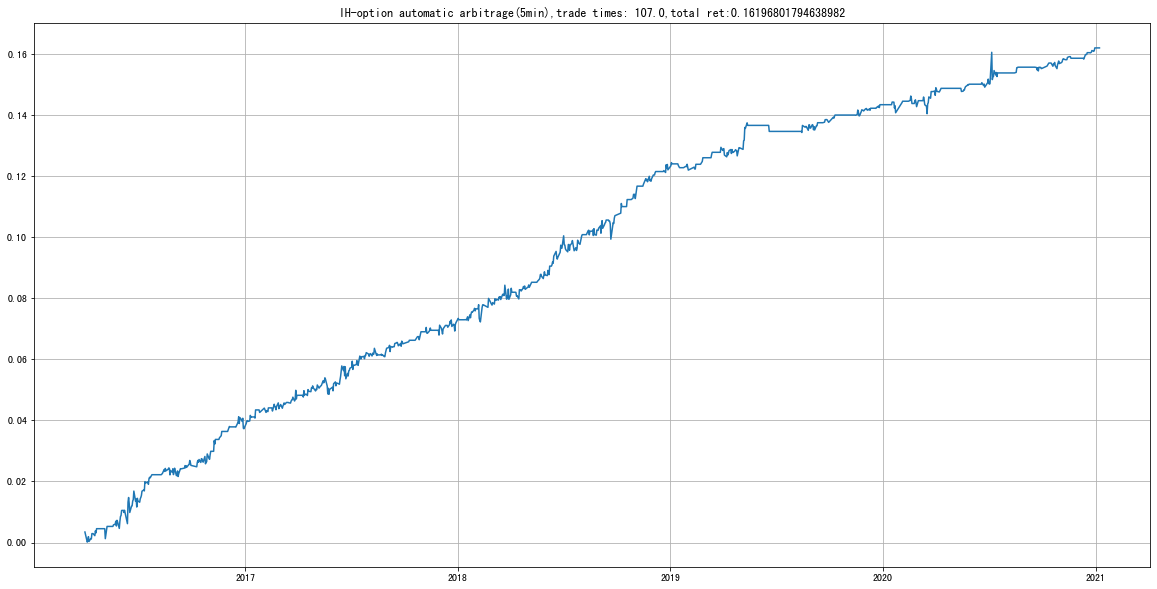

In [17]:
daily['Date']=daily.date.apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d'))
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(daily.Date,daily.ret.cumsum())
plt.title('IH-option automatic arbitrage(5min),trade times: '+str((pos.shape[0]+neg.shape[0])/2)+',total ret:'+str(daily.ret.sum()))


以下统计开平仓的交易点位、时间和持仓时间

In [18]:
pos_period=pd.DataFrame()
pos_period['open']=pos.loc[pos.trade==1,'date'].tolist()
pos_period['open_cash']=pos.loc[pos.trade==1,'cash_flow'].tolist()
pos_period['close']=pos.loc[pos.trade==-1,'date'].tolist()
pos_period['close_cash']=pos.loc[pos.trade==-1,'cash_flow'].tolist()
pos_period['ret']=pos_period['open_cash']+pos_period['close_cash']
pos_period['holding_day']=(pos_period.close.apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))-pos_period.open.apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))).apply(lambda x:x.days)

In [19]:
neg_period=pd.DataFrame()
neg_period['open']=neg.loc[neg.trade==-1,'date'].tolist()
neg_period['open_cash']=neg.loc[neg.trade==-1,'cash_flow'].tolist()
neg_period['close']=neg.loc[neg.trade==1,'date'].tolist()
neg_period['close_cash']=neg.loc[neg.trade==1,'cash_flow'].tolist()
neg_period['ret']=neg_period['open_cash']+neg_period['close_cash']
neg_period['holding_day']=(neg_period.close.apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))-neg_period.open.apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))).apply(lambda x:x.days)